This jupyter notebook is used for calculating and plotting different methods of determining clusters for a system of disperse particles.

In [1]:
# importing the neccessary modules

import csv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# reading in the csv file

csvarray = []
filelocation = '/Users/zack/Documents/Documents/csv_data_files/'
filename = 'box512_ht_1_loc/box512_ht_1_loc.0'
tablename = 'minimum_distance/'
with open(filelocation + filename + '.csv', 'r') as csvfile:
    csv_data = list(csv.reader(csvfile, delimiter=","))
#print (csv_data[:3])
csvarray = np.array(csv_data[1:], dtype=np.float) # Remove headers and convert to floats
#print (csvarray[:3])

In [3]:
# Variables

x_len = 512 # Length of x axis
y_len = 256 # Length of y axis

# The following variables are pulled from the csv file

num_part = len(csvarray) # Number of particles
#print (num_part)
x = csvarray[:,7]
y = csvarray[:,8]
rad = np.mean(csvarray[:, 1])/2
#print (rad)

#print (x[:3])
#print (len(x))

The following code is for calculating the R value of the simulations at distinct timesteps. $$R = \frac{r_A}{r_E}$$ Where $$r_A = \frac{1}{N}{\sum_{i=1}^n \sum_{j=1}^n}_{i \neq j}d_{ij}$$here $d_{ij}$ is the distance for the nearest neighbor j to particle i and N is the number of particles, and $$r_E = \frac{1}{2 \sqrt{\lambda}}$$ Where $\lambda = N/A$ A is the area of the domain.

In [ ]:
# A function that creates an array of the particles within a set distance from the selected particle

def domain_reduction(arr, j, x, y, radius):
    arr_red = []
    x_pos = arr[j, x]
    y_pos = arr[j, y]
    #print (x_pos)
    for i in range(0, len(arr)):
        if arr[i, x] - arr[i, 1]/2 < x_pos + arr[j, 1]/2 + radius and \
        arr[i, x] + arr[i, 1]/2 > x_pos - arr[j, 1]/2 - radius:
            if arr[i, y] - arr[i, 1]/2 < y_pos + arr[j, 1]/2 + radius and arr[i, y] + arr[i, 1]/2 > \
            y_pos - arr[j, 1]/2 - radius:
                arr_red.append(arr[i])
    arr_red = np.array(arr_red)
    #print (arr_red)
    return arr_red
    

In [ ]:
# Creating an array of the nearest neighbors and which particles are the nearest.

num_of_it = len(x)
#print (num_of_it)
min_array = []

for i in range(0, num_of_it):
    
    if i % 1000 == 0:
        print (i)
#    print (i)    
    near_neigh = []
    #print (near_neigh)
    
    # Creating an array that is reduced to particles within a set radius.
    red_arr = domain_reduction(csvarray, i, 7, 8, 5) 
    #print (len(red_arr))
    #print (red_arr)
    
    for n in range(0, len(red_arr)):
        if csvarray[i, 0] != red_arr[n, 0]:
            distance = np.sqrt((csvarray[i, 7] - red_arr[n, 7])**2 + (csvarray[i, 8] - red_arr[n, 8])**2) - \
            ((csvarray[i, 1]/2) + (red_arr[n, 1]/2))
            arr = np.array([csvarray[i, 0], red_arr[n, 0], distance])
            #print (arr)
            near_neigh.append(arr)
        
    near_neigh = np.array(near_neigh) # Converts the list into an array
    #print (near_neigh)
    min_dist = np.amin(near_neigh[:, 2])
    min_index = np.argmin(near_neigh[:, 2]) # Gives the index of the minimum value in the near_neigh array
    #print (min_index)
    min_array.append(near_neigh[min_index])
min_array = np.array(min_array)
#print (min_array)
        
            

In [ ]:
# Writing nearest neighbor data to csv


with open(filelocation + tablename + filename + '.csv', 'w', newline='') as f:
    writer=csv.writer(f)
    writer.writerow(['original particle', 'nearest neighbor', 'distance'])
    writer.writerows(min_array)


Run this next cell only if the previous cells have been run for the desired simulation at least once. The reading of the file prevents the need of running the cell that creates the array of the nearest neighbors.  Cells 2, 3, and 4 still need to be run prior to running the upcoming cells.

In [4]:
# reading the nearest neighbor data from csv

with open(filelocation + tablename + filename + '.csv', 'r') as csvminfile:
    csv_min = list(csv.reader(csvminfile, delimiter=","))
#print (csv_data[:3])
min_array = np.array(csv_min[1:], dtype=np.float) # Remove headers and convert to floats
#print (csvarray[:3])

In [5]:
# Finding the mean distance rA

#print(min_array[:, 2])
rA = np.mean(min_array[:, 2])
print ("{:2.3f}".format(rA))

1.106


In [6]:
# Calculating rE the expected value

# Intensity with the area of the particles taken into consideration
lam = num_part / ((x_len * y_len) - len(x)*(np.pi*rad**2)) 
print ("{:2.4f}".format(lam))

rE = 1 / (2 * np.sqrt(lam))
print ("{:2.2f}".format(rE))

0.1212
1.44


In [7]:
# Calculating R ratio of the actual value to the expected value.  
# It R is greater than 1 there is ordering and if R is less than 1 there is clustering.
# an R value of 1 is undetermined.

R = rA / rE
print ("{:2.2f}".format(R))


0.77


This next section calculates Rippley's K value and then calculates the L value and plots L vs radius (distance from original particle).  Plotted along with the L value is the instance when the particle distribution is completely random, or when L = r.  If the plot is above the random line there is clustering and if the plot is below the line there is ordering.

In [11]:
# The purpose of this function is to calculate the distance between the selected particle and all the other particles.
# To do this an array of particles is created where the particles are all within a distance slightly greater than the
# radius of interest.  Anoter array is created that has only the particles within the defined radius, and the number
# of particles within that array is returned to the calling script.

def part_in_rad(arr, part_num, x_val, y_val, radius):
    
    num_part = []
    smallarr = []
    
    # creating the box around the selected particle and only keeping the particles within that box.
    for k in range(0, len(arr)):
        if arr[part_num, x_val] - arr[part_num, 1]/2 - radius - 0.5 < arr[k, x_val] + arr[k, 1]/2 and \
        arr[part_num, x_val] + arr[part_num, 1]/2 + radius + 0.5 > arr[k, x_val] - arr[k, 1]/2  and \
        arr[part_num, y_val] - arr[part_num, 1]/2 - radius - 0.5 < arr[k, y_val] + arr[k, 1]/2 and \
        arr[part_num, y_val] + arr[part_num, 1]/2 + radius + 0.5 > arr[k, y_val] - arr[k, 1]/2 and part_num != k:
            smallarr.append(arr[k])
            #print (smallarr)
    smallarr = np.array(smallarr)
    #print (smallarr)
    
    # Finding the particles within the radius of the selected particle.
    for i in range(0, len(smallarr)):
        #print (i)
        dist = np.sqrt((arr[part_num, x_val] - smallarr[i, x_val])**2 + \
        (arr[part_num, y_val] - smallarr[i, y_val])**2) - (arr[part_num, 1]/2 + smallarr[i, 1]/2)
        if dist <= radius and dist > 0:
            #print (arr[i, :])
            num_part.append(smallarr[i])
            #print(num_part)
        #print (num_part)
    num_part = np.array(num_part)
    #print (num_part)
    #print (len(num_part))        
    Np = len(num_part)
    #print (Np)
#    return num_part

    # Returning the number of particles within the radius.
    if len(num_part) == 0:
        return 0
    else:
        return Np

In [12]:
# Calculating k(r)
Kr = []

radius = [0, rad, rad*2, rad*3, rad*4, rad*5, rad*6, rad*7, rad*8, rad*9, rad*10, rad*11, rad*12, rad*13, rad*14]
#print (len(radius))
for i in radius:
    print ("{:2.2f}".format(i))
    kr = []
    arr = []
    for n in range(0, len(csvarray)):
        #print (n)
        if csvarray[n, 7] - csvarray[n, 1]/2 >= i and csvarray[n, 7] + csvarray[n, 1]/2 <= x_len - i and \
        csvarray[n, 8] - csvarray[n, 1]/2 >= i and csvarray[n, 8] + csvarray[n, 1]/2 <= y_len - i:
            num_part = part_in_rad(csvarray, n, 7, 8, i)
            #arr.append(num_part)
            #np.append(arr, num_part)
            #print (arr)
            #particle = len(arr)
            kr.append(num_part / lam)
            #print (kr)
    Kr.append(np.mean(kr))
Kr = np.array(Kr)

# This is to correct for overlapping particles where the distance between 
# particles in the simulation could be less than 0.
Kr[0] = 0 
#print (Kr)

Lr = np.sqrt(Kr / np.pi)
np.set_printoptions(precision=2)
print (Lr)

0
0.200000005
0.40000001
0.600000015
0.80000002
1.000000025
1.20000003
1.400000035
1.60000004
1.800000045
2.00000005
2.200000055
2.40000006
2.600000065
2.80000007
[ 0.    0.42  0.66  0.9   1.11  1.33  1.54  1.74  1.94  2.15  2.35  2.55
  2.76  2.95  3.16]


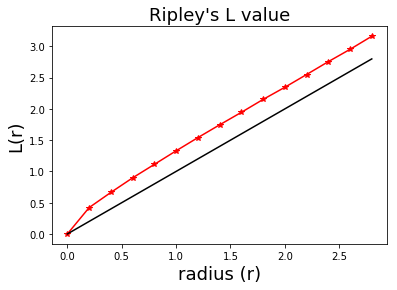

In [20]:
plt.plot(radius, Lr, 'r*-')
plt.plot(radius, radius, 'k-')
plt.title("Ripley's L value", fontsize = 18 )
plt.xlabel('radius (r)', fontsize = 18)
plt.ylabel('L(r)', fontsize = 18)
plt.show()

This final section calculates Rippley's g value.  This value looks at the slope of the K value and normalized it to the random distribution $2 \pi r$.  If K is random it is equal to $\pi r^2$, so the slope is $2 \pi r$.  That means a random g value is equal to 1 for any r.  If the plot of the simulation is above the random line there is clustering and if it is below there is ordering.

In [14]:
gr = []

for i in range(1, len(radius)):
    dkr = (Kr[i] - Kr[i-1]) / (radius[i] - radius[i-1])
    #print (dkr)
    gr.append(dkr / (2 * np.pi * radius[i]))
gr = np.array(gr)
print (gr)

[ 2.22  1.65  1.52  1.35  1.32  1.26  1.2   1.15  1.18  1.09  1.13  1.14
  1.08  1.14]


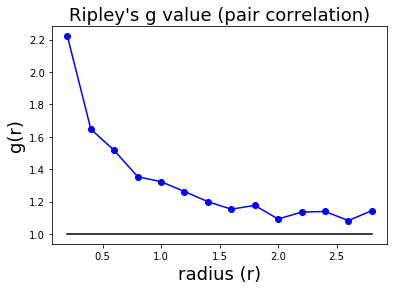

In [21]:
plt.plot(radius[1:len(radius)], gr, 'bo-')
plt.plot(radius[1:len(radius)], np.ones(len(gr)), 'k-')
plt.title("Ripley's g value (pair correlation)", fontsize = 18)
plt.xlabel('radius (r)', fontsize = 18)
plt.ylabel('g(r)', fontsize = 18)
plt.show()